# Movie Recommendation using Netflix Movie Reviews




This project aims to build a movie recommendation system using Netflix Movie Ratings. There are 17337458 Ratings given by 143458 users to 1350 movies. Ratings are in the form of Integer i.e. 1 - 5


**Table of Content**



#### 1.  Load Rating Data
#### 2.  Load Movie Data
#### 3.  Analyze Data
#### 4.  Recommendation Model
#### 4.1 Collaborative Filtering - SVD
#### 4.2 Pearson Correlation Method

In [ ]:
pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162998 sha256=6dc7dedcdc2fe6365bf31616f23ed68a6b593adae8f6a0d69c29418860bcd36e
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import numpy as np
from surprise import Reader, Dataset, SVD
from surprise import accuracy
from surprise.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot

# 1. Load Rating Data

In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Recsys/Netflix_Dataset_Rating.csv'
df = pd.read_csv(path)
df

,User_ID,Rating,Movie_ID
0,712664,5,3
1,1331154,4,3
2,2632461,3,3
3,44937,5,3
4,656399,4,3
...,...,...,...
17337453,520675,3,4496
17337454,1055714,5,4496
17337455,2643029,4,4496
17337456,1559566,3,4496


In [ ]:
df.dtypes

User_ID     int64
Rating      int64
Movie_ID    int64
dtype: object

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17337458 entries, 0 to 17337457
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   User_ID   int64
 1   Rating    int64
 2   Movie_ID  int64
dtypes: int64(3)
memory usage: 396.8 MB


In [ ]:
df['Rating'].describe().astype('int')

count    17337458
mean            3
std             1
min             1
25%             3
50%             4
75%             4
max             5
Name: Rating, dtype: int64

In [ ]:
print("Unique Values :\n",df.nunique())

Unique Values :
 User_ID     143458
Rating           5
Movie_ID      1350
dtype: int64


# 2. Load Movie Data

In [ ]:
df_title = pd.read_csv('/content/drive/MyDrive/Recsys/Netflix_Dataset_Movie.csv')
df_title

,Movie_ID,Year,Name
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004,Fidel Castro: American Experience
17767,17768,2000,Epoch
17768,17769,2003,The Company


In [ ]:
df_title.dtypes

Movie_ID     int64
Year         int64
Name        object
dtype: object

In [ ]:
df_title.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Movie_ID  17770 non-null  int64 
 1   Year      17770 non-null  int64 
 2   Name      17770 non-null  object
dtypes: int64(2), object(1)
memory usage: 416.6+ KB


In [ ]:
df_title['Year'].describe().astype('int')

count    17770
mean      1990
std         16
min       1915
25%       1985
50%       1997
75%       2002
max       2005
Name: Year, dtype: int64

In [ ]:
print("Unique Values :\n",df_title.nunique())

Unique Values :
 Movie_ID    17770
Year           91
Name        17297
dtype: int64


# 3. Analyze Data

In [ ]:
no_of_rated_products_per_users = df.groupby(by='User_ID')['Rating'].count().sort_values(ascending=False)
no_of_rated_products_per_users.head()

User_ID
305344     1344
387418     1339
2439493    1324
2118461    1305
1664010    1257
Name: Rating, dtype: int64

In [ ]:
no_of_rated_products_per_users.describe()


count    143458.000000
mean        120.853895
std          79.783702
min           5.000000
25%          67.000000
50%          95.000000
75%         147.000000
max        1344.000000
Name: Rating, dtype: float64

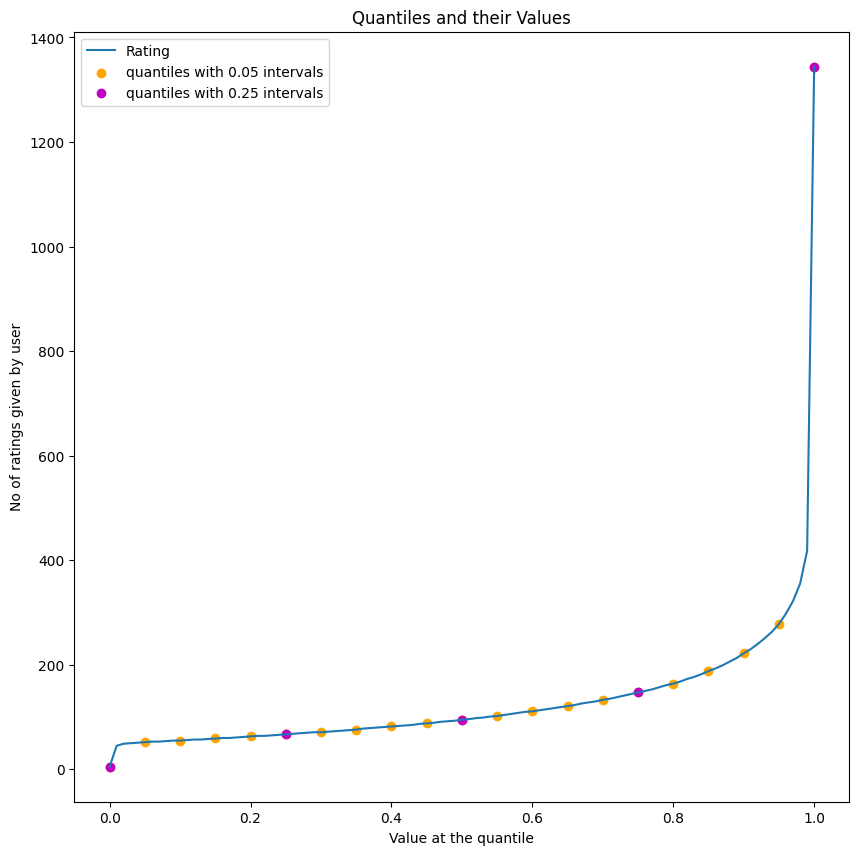

In [ ]:
quantiles = no_of_rated_products_per_users.quantile(np.arange(0,1.01,0.01), interpolation='higher')

plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings given by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [ ]:
no_of_rated_products_per_movies = df.groupby(by='Movie_ID')['Rating'].count().sort_values(ascending=False)
no_of_rated_products_per_movies.head()

Movie_ID
1905    117075
2452    102721
4306    102376
571     101450
3860     98545
Name: Rating, dtype: int64

In [ ]:
no_of_rated_products_per_movies.describe()

count      1350.000000
mean      12842.561481
std       17805.334719
min        1042.000000
25%        2607.750000
50%        5229.000000
75%       14792.000000
max      117075.000000
Name: Rating, dtype: float64

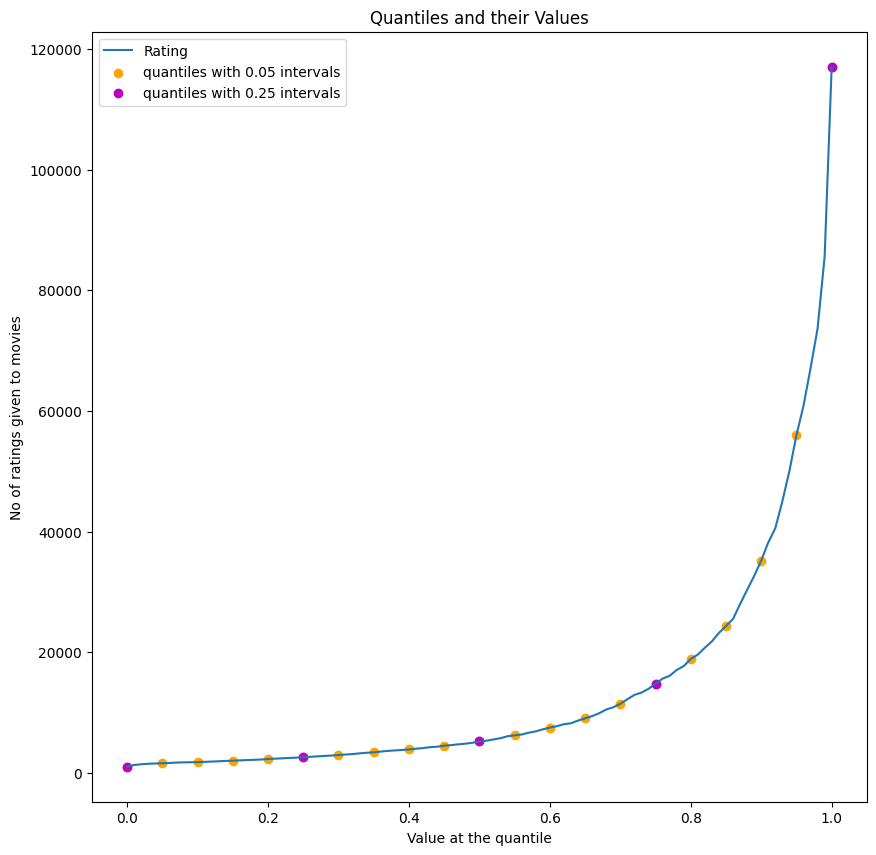

In [ ]:
quantiles = no_of_rated_products_per_movies.quantile(np.arange(0,1.01,0.01), interpolation='higher')

plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings given to movies')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [ ]:
f = ['count','mean']
df_movie_summary = df.groupby('Movie_ID')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

df__title = df_title.set_index('Movie_ID')

In [ ]:
data = df['Rating'].value_counts()

trace = go.Bar(x = data.index,y = data.values,text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],textposition = 'auto')

layout = dict(title = 'Distribution of {} Movie-ratings'.format(df.shape[0]), xaxis = dict(title = 'Rating'), yaxis = dict(title = 'Movies'))

fig = go.Figure(data=[trace], layout=layout)

iplot(fig)

In [ ]:
data = df_title['Year'].value_counts()

trace = go.Bar(x = data.index,y = data.values,text = ['{:.1f} %'.format(val) for val in (data.values / df_title.shape[0] * 100)],textposition = 'auto')

layout = dict(title = 'Distribution of {} Movie - Year-wise'.format(df.shape[0]), xaxis = dict(title = 'Year'), yaxis = dict(title = 'Movies'))

fig = go.Figure(data=[trace], layout=layout)

iplot(fig)

In [ ]:
df_2004 = df_title[df_title['Year']==2004]
df_2004 = df_2004.merge(df,on='Movie_ID')

data = df_2004['Rating'].value_counts()

trace = go.Bar(x = data.index,y = data.values,text = ['{:.1f} %'.format(val) for val in (data.values / df_2004.shape[0] * 100)],textposition = 'auto')

layout = dict(title = 'Distribution of {} Movie-ratings released in 2004'.format(df.shape[0]), xaxis = dict(title = 'Rating'), yaxis = dict(title = 'Movies'))

fig = go.Figure(data=[trace], layout=layout)

iplot(fig)

In [ ]:
df_max_ratings = df_movie_summary[df_movie_summary['count']==df_movie_summary['count'].max()]

req_MID = df_max_ratings.index[0]
df_max_ratings = df[df['Movie_ID'] ==req_MID]

Movie_name_max_raings = df_title['Name'][df_title['Movie_ID']==req_MID].to_string(index=False)

data = df_max_ratings['Rating'].value_counts()

trace = go.Bar(x = data.index,y = data.values,text = ['{:.1f} %'.format(val) for val in (data.values / df_max_ratings.shape[0] * 100)],textposition = 'auto')

layout = dict(title = 'Distribution of Most Rated Movie -'+Movie_name_max_raings+ ' Movie-Ratings')

fig = go.Figure(data=[trace], layout=layout)

iplot(fig)

# 4. Recommendation Model


## 4.1 Collaborative Filtering - SVD

In [ ]:
model = SVD(n_epochs=10,verbose = True)

data = Dataset.load_from_df(df[['User_ID', 'Movie_ID', 'Rating']], Reader())

trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

trainset = data.build_full_trainset()

model.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9


In [ ]:
predictions = model.test(testset)

accuracy.rmse(predictions, verbose=True)

RMSE: 0.8294


0.8294103584980294

In [ ]:
def Recommendation(given_user_id,n_movies):
    given_user = df_title.copy()
    given_user = given_user.reset_index()
    given_user = given_user[~given_user['Movie_ID'].isin(drop_movie_list)]


    given_user['Estimated_Rating'] = given_user['Movie_ID'].apply(lambda x: model.predict(given_user_id, x).est)

    given_user = given_user.drop('Movie_ID', axis = 1)

    given_user = given_user.sort_values('Estimated_Rating', ascending=False)
    given_user.drop(['index'], axis = 1,inplace=True)
    given_user.reset_index(inplace=True,drop=True)
    return given_user.head(n_movies)

### Movie Recommendation for User - 712664

In [ ]:
Recommendation(712664,10)

,Year,Name,Estimated_Rating
0,1992,Reservoir Dogs,4.961814
1,1954,Seven Samurai,4.938434
2,1990,The Simpsons: Treehouse of Horror,4.911177
3,1991,The Simpsons: Season 3,4.890595
4,1989,The Simpsons: Season 1,4.782447
5,1974,The Godfather,4.746545
6,1959,North by Northwest,4.684310
7,1949,The Third Man,4.657110
8,2001,Wallace & Gromit in Three Amazing Adventures,4.650562
9,1979,Alien: Collector's Edition,4.597436


### Movie Recommendation for User - 2643029

In [ ]:
Recommendation(2643029,10)

,Year,Name,Estimated_Rating
0,1954,Seven Samurai,4.717496
1,1995,Pride and Prejudice,4.626007
2,2002,Spirited Away,4.623487
3,1949,The Third Man,4.549210
4,1959,North by Northwest,4.525154
5,2002,The Pianist,4.507561
6,2001,Wallace & Gromit in Three Amazing Adventures,4.501414
7,1990,The Simpsons: Treehouse of Horror,4.499609
8,1997,Princess Mononoke,4.469290
9,2003,Whale Rider,4.466295
